# Python Numerical Tools

## 4. scipy

The scipy package contains various toolboxes dedicated to common issues in scientific computing. Its different submodules correspond to different applications, such as interpolation, integration, optimization, image processing, statistics, special functions, etc.

scipy is the core package for scientific routines in Python; it is meant to operate efficiently on numpy arrays, so that numpy and scipy work hand in hand.

Before implementing a routine, it is worth checking if the desired data processing is not already implemented in Scipy. Scipy’s routines are optimized and tested, and should therefore be used when possible.


### Linear algebra operations: scipy.linalg

The scipy.linalg module provides standard linear algebra operations, relying on an underlying efficient implementation (BLAS, LAPACK).

#### The scipy.linalg.det() function computes the determinant of a square matrix:

In [3]:
import numpy as np
from scipy import linalg

arr = np.array([[1, 2],
                [3, 4]])
linalg.det(arr)

-2.0

In [4]:
arr = np.array([[3, 2],
                [6, 4]])
linalg.det(arr) 

0.0

In [5]:
linalg.det(np.ones((3, 4)))

ValueError: expected square matrix

#### The scipy.linalg.inv() function computes the inverse of a square matrix:

In [6]:
arr = np.array([[1, 2],
                [3, 4]])
iarr = linalg.inv(arr)
iarr

array([[-2. ,  1. ],
       [ 1.5, -0.5]])

In [7]:
np.allclose(np.dot(arr, iarr), np.eye(2))

True

Finally computing the inverse of a singular matrix (its determinant is zero) will raise LinAlgError:

In [8]:
arr = np.array([[3, 2],
                [6, 4]])
linalg.inv(arr)

LinAlgError: singular matrix

More advanced operations are available, for example singular-value decomposition (SVD):

In [9]:
arr = np.arange(9).reshape((3, 3)) + np.diag([1, 0, 1])
uarr, spec, vharr = linalg.svd(arr)

In [10]:
uarr

array([[-0.1617463 , -0.98659196,  0.02178164],
       [-0.47456365,  0.09711667,  0.87484724],
       [-0.86523261,  0.13116653, -0.48390895]])

In [11]:
spec

array([ 14.88982544,   0.45294236,   0.29654967])

In [12]:
vharr

array([[-0.45513179, -0.54511245, -0.70406496],
       [ 0.20258033,  0.70658087, -0.67801525],
       [-0.86707339,  0.45121601,  0.21115836]])

The original matrix can be re-composed by matrix multiplication of the outputs of svd with np.dot:

In [16]:
sarr = np.diag(spec)
svd_mat = uarr@sarr@vharr
svd_mat

array([[ 1.,  1.,  2.],
       [ 3.,  4.,  5.],
       [ 6.,  7.,  9.]])

In [15]:
arr

array([[1, 1, 2],
       [3, 4, 5],
       [6, 7, 9]])

In [17]:
np.allclose(svd_mat, arr)

True

SVD is commonly used in statistics and signal processing. Many other standard decompositions (QR, LU, Cholesky, Schur), as well as solvers for linear systems, are available in scipy.linalg.

### Interpolation: scipy.interpolate

scipy.interpolate is useful for fitting a function from experimental data and thus evaluating points where no measure exists. The module is based on the FITPACK Fortran subroutines.

By imagining experimental data close to a sine function:

In [18]:
measured_time = np.linspace(0, 1, 10)
noise = (np.random.random(10)*2 - 1) * 1e-1
measures = np.sin(2 * np.pi * measured_time) + noise

scipy.interpolate.interp1d can build a linear interpolation function:

In [19]:
from scipy.interpolate import interp1d
linear_interp = interp1d(measured_time, measures)

Then the result can be evaluated at the time of interest:

In [20]:
interpolation_time = np.linspace(0, 1, 50)
linear_results = linear_interp(interpolation_time)

A cubic interpolation can also be selected by providing the kind optional keyword argument:

In [22]:
cubic_interp = interp1d(measured_time, measures, kind='cubic')
cubic_results = cubic_interp(interpolation_time)

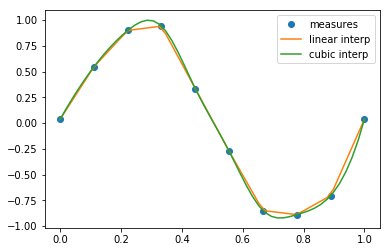

In [24]:
from matplotlib import pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(measured_time, measures, 'o', ms=6, label='measures')
plt.plot(interpolation_time, linear_results, label='linear interp')
plt.plot(interpolation_time, cubic_results, label='cubic interp')
plt.legend()
plt.show()

scipy.interpolate.interp2d is similar to scipy.interpolate.interp1d, but for 2-D arrays. Note that for the interp family, the interpolation points must stay within the range of given data points.

### Optimization and fit: scipy.optimize

Optimization is the problem of finding a numerical solution to a minimization or equality.

The scipy.optimize module provides algorithms for function minimization (scalar or multi-dimensional), curve fitting and root finding.

#### Curve fitting

Suppose we have data on a sine wave, with some noise:

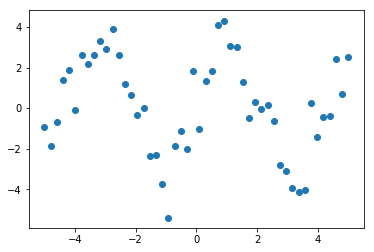

In [27]:
# First generate some data

import numpy as np

# Seed the random number generator for reproducibility
np.random.seed(0)

x_data = np.linspace(-5, 5, num=50)
y_data = 2.9 * np.sin(1.5 * x_data) + np.random.normal(size=50)

# And plot it
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.scatter(x_data, y_data)

plt.show()

If we know that the data lies on a sine wave, but not the amplitudes or the period, we can find those by least squares curve fitting. First we have to define the test function to fit, here a sine with unknown amplitude and period:

In [29]:
from scipy import optimize

def test_func(x, a, b):
    return a * np.sin(b * x)

params, params_covariance = optimize.curve_fit(test_func, x_data, y_data,
                                               p0=[2, 2])

print(params)

[ 3.05931973  1.45754553]


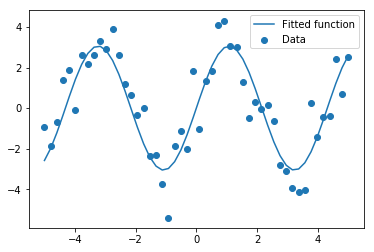

In [30]:
# And plot the resulting curve on the data

plt.figure(figsize=(6, 4))
plt.scatter(x_data, y_data, label='Data')
plt.plot(x_data, test_func(x_data, params[0], params[1]),
         label='Fitted function')

plt.legend(loc='best')

plt.show()

#### Curve fitting: temperature as a function of month of the year

We have the min and max temperatures in Alaska for each months of the year. We would like to find a function to describe this yearly evolution.

For this, we will fit a periodic function.


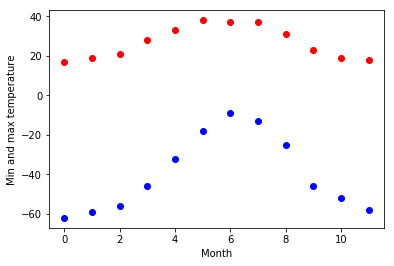

In [32]:
# The data

import numpy as np

temp_max = np.array([17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18])
temp_min = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])

import matplotlib.pyplot as plt
months = np.arange(12)
plt.plot(months, temp_max, 'ro')
plt.plot(months, temp_min, 'bo')
plt.xlabel('Month')
plt.ylabel('Min and max temperature')

plt.show()

In [33]:
# Fitting it to a periodic function

from scipy import optimize
def yearly_temps(times, avg, ampl, time_offset):
    return (avg
            + ampl * np.cos((times + time_offset) * 2 * np.pi / times.max()))

res_max, cov_max = optimize.curve_fit(yearly_temps, months,
                                      temp_max, [20, 10, 0])
res_min, cov_min = optimize.curve_fit(yearly_temps, months,
                                      temp_min, [-40, 20, 0])

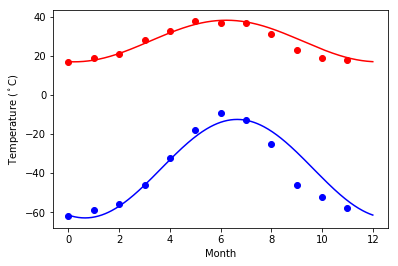

In [34]:
# Plotting the fit

days = np.linspace(0, 12, num=365)

plt.figure()
plt.plot(months, temp_max, 'ro')
plt.plot(days, yearly_temps(days, *res_max), 'r-')
plt.plot(months, temp_min, 'bo')
plt.plot(days, yearly_temps(days, *res_min), 'b-')
plt.xlabel('Month')
plt.ylabel('Temperature ($^\circ$C)')

plt.show()

#### Finding the minimum of a scalar function

Let’s define the following function:

In [35]:
def f(x):
    return x**2 + 10*np.sin(x)

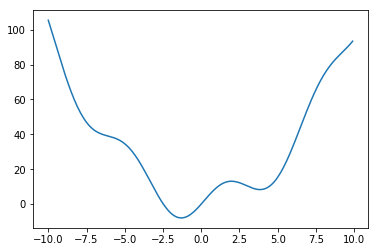

In [42]:
# and plot it:

x = np.arange(-10, 10, 0.1)

plt.plot(x, f(x)) 

plt.show() 

This function has a global minimum around -1.3 and a local minimum around 3.8.

Searching for minimum can be done with scipy.optimize.minimize(), given a starting point x0, it returns the location of the minimum that it has found:

In [37]:
result = optimize.minimize(f, x0=0)
result 

      fun: -7.945823375615215
 hess_inv: array([[ 0.08589237]])
      jac: array([ -1.19209290e-06])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 5
     njev: 6
   status: 0
  success: True
        x: array([-1.30644012])

In [38]:
result.x # The coordinate of the minimum  

array([-1.30644012])

**Methods**: As the function is a smooth function, gradient-descent based methods are good options. The lBFGS algorithm is a good choice in general:

In [39]:
optimize.minimize(f, x0=0, method="L-BFGS-B")  

      fun: array([-7.94582338])
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.42108547e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 12
      nit: 5
   status: 0
  success: True
        x: array([-1.30644013])

**Note**

Note how it cost only 12 functions evaluation above to find a good value for the minimum.


**Global minimum**: A possible issue with this approach is that, if the function has local minima, the algorithm may find these local minima instead of the global minimum depending on the initial point x0:




In [40]:
res = optimize.minimize(f, x0=3, method="L-BFGS-B")
res.x

array([ 3.83746709])

If we don’t know the neighborhood of the global minimum to choose the initial point, we need to resort to costlier global optimization. To find the global minimum, we use scipy.optimize.basinhopping() (added in version 0.12.0 of Scipy). It combines a local optimizer with sampling of starting points:


In [41]:
optimize.basinhopping(f, 0) 

                        fun: -7.945823375615284
 lowest_optimization_result:       fun: -7.945823375615284
 hess_inv: array([[ 0.08584502]])
      jac: array([  1.19209290e-07])
  message: 'Optimization terminated successfully.'
     nfev: 15
      nit: 3
     njev: 5
   status: 0
  success: True
        x: array([-1.30644001])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 1533
                        nit: 100
                       njev: 511
                          x: array([-1.30644001])

**Constraints**: We can constrain the variable to the interval (0, 10) using the “bounds” argument:

As minimize() works in general with x multidimensionsal, the “bounds” argument is a list of bound on each dimension.

In [43]:
res = optimize.minimize(f, x0=1, bounds=((0, 10), ))
res.x    

array([ 0.])

#### Optimization of a two-parameter function

$$
f(x,y) = (4 - 2.1x^2 + \frac {x^4}{3})x^2 + xy + (4y^2 - 4)y^2
$$

In [44]:
import numpy as np


# Define the function that we are interested in
def sixhump(x):
    return ((4 - 2.1*x[0]**2 + x[0]**4 / 3.) * x[0]**2 + x[0] * x[1]
            + (-4 + 4*x[1]**2) * x[1] **2)

# Make a grid to evaluate the function (for plotting)
x = np.linspace(-2, 2)
y = np.linspace(-1, 1)
xg, yg = np.meshgrid(x, y)

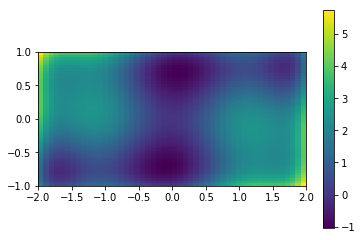

In [46]:
# Simple visualization in 2D

import matplotlib.pyplot as plt
plt.figure()
plt.imshow(sixhump([xg, yg]), extent=[-2, 2, -1, 1])
plt.colorbar()

plt.show()


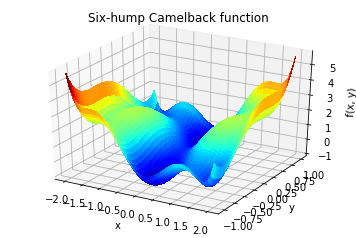

In [48]:
# A 3D surface plot of the function

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(xg, yg, sixhump([xg, yg]), rstride=1, cstride=1,
                       cmap=plt.cm.jet, linewidth=0, antialiased=False)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')
ax.set_title('Six-hump Camelback function')

plt.show()

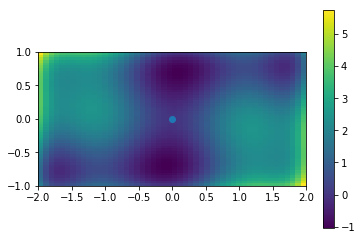

In [49]:
# Find the minima

from scipy import optimize

x_min = optimize.minimize(sixhump, x0=[0, 0])

plt.figure()
# Show the function in 2D
plt.imshow(sixhump([xg, yg]), extent=[-2, 2, -1, 1])
plt.colorbar()
# And the minimum that we've found:
plt.scatter(x_min.x[0], x_min.x[1])

plt.show()

###  Finding the roots of a scalar function

To find a root, i.e. a point where $f(x) = 0$, of the function $f$ above we can use scipy.optimize.root():

In [51]:
root = optimize.root(f, x0=1)  # our initial guess is 1
root

    fjac: array([[-1.]])
     fun: array([ 0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([  1.33310463e-32])
       r: array([-10.])
  status: 1
 success: True
       x: array([ 0.])

In [52]:
root.x  # Only the root found

array([ 0.])

Note that only one root is found. Inspecting the plot of $f$ reveals that there is a second root around -2.5. We find the exact value of it by adjusting our initial guess:

In [53]:
root2 = optimize.root(f, x0=-2.5)
root2.x

array([-2.47948183])

**Note**

scipy.optimize.root() also comes with a variety of algorithms, set via the “method” argument.

Now that we have found the minima and roots of f and used curve fitting on it, we put all those results together in a single plot:

Global minima found [-1.30641113]
Local minimum found 3.8374671195


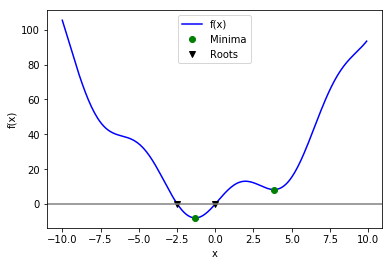

In [56]:
x = np.arange(-10, 10, 0.1)
def f(x):
    return x**2 + 10*np.sin(x)

# Global optimization
grid = (-10, 10, 0.1)
xmin_global = optimize.brute(f, (grid, ))
print("Global minima found %s" % xmin_global)

# Constrain optimization
xmin_local = optimize.fminbound(f, 0, 10)
print("Local minimum found %s" % xmin_local)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)

# Plot the function
ax.plot(x, f(x), 'b-', label="f(x)")

# Plot the minima
xmins = np.array([xmin_global[0], xmin_local])
ax.plot(xmins, f(xmins), 'go', label="Minima")

# Plot the roots
roots = np.array([root.x, root2.x])
ax.plot(roots, f(roots), 'kv', label="Roots")

# Decorate the figure
ax.legend(loc='best')
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.axhline(0, color='gray')

plt.show()

### Statistics and random numbers: scipy.stats

The module scipy.stats contains statistical tools and probabilistic descriptions of random processes. Random number generators for various random process can be found in numpy.random.

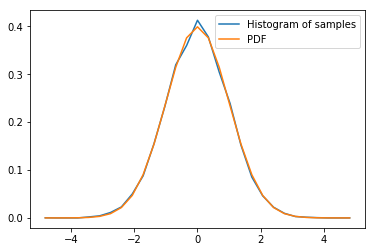

In [71]:
samples = np.random.normal(size=10000)

# Compute a histogram of the sample
bins = np.linspace(-5, 5, 30)
histogram, bins = np.histogram(samples, bins=bins, normed=True)

bin_centers = 0.5*(bins[1:] + bins[:-1])
pdf = stats.norm.pdf(bin_centers)  # norm is a distribution object

plt.figure(figsize=(6, 4))
plt.plot(bin_centers, histogram, label="Histogram of samples")
plt.plot(bin_centers, pdf, label="PDF")
plt.legend()
plt.show()

In [72]:
loc, std = stats.norm.fit(samples)
loc 

-0.0087633264793032829

In [73]:
std  

1.0030472378013311

#### Mean, median and percentiles

The mean is an estimator of the center of the distribution:

In [74]:
np.mean(samples)     

-0.0087633264793032829

The median another estimator of the center. It is the value with half of the observations below, and half above:
Unlike the mean, the median is not sensitive to the tails of the distribution. It is “robust”.

In [75]:
np.median(samples)

-0.0061209028519400768

The median is also the percentile 50, because 50% of the observation are below it:

In [76]:
stats.scoreatpercentile(samples, 50)  

-0.0061209028519400768

Similarly, we can calculate the percentile 90: